# Point Transformer
Based on https://github.com/lucidrains/point-transformer-pytorch

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install point-transformer-pytorch

## Load Dataset

In [ ]:
!pip install open3d 1>/dev/null
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!git pull
from datasets.shapenet_data_pc import ShapeNet15kPointClouds
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
dataset = ShapeNet15kPointClouds(root_dir=shapenet_location, tr_sample_size=1024, te_sample_size=1024)
from metrics.chamfer_distance import np_chamfer_distance
from visuals.visuals_util import visualize_pointcloud_eval, visualize_pointcloud_eval_three

In [ ]:
from visuals.visuals_util import visualize_pointcloud_eval, visualize_pointcloud_eval_three

## Load Model

In [ ]:
import torch
from point_transformer_pytorch import PointTransformerLayer

attn = PointTransformerLayer(
    dim = 128,
    pos_mlp_hidden_dim = 64,
    attn_mlp_hidden_mult = 4,
    num_neighbors = 16          # only the 16 nearest neighbors would be attended to for each point
)

feats = torch.randn(1, 16, 128)
pos = torch.randn(1, 16, 3)
mask = torch.ones(1, 16).bool()

attn(feats, pos) # (1, 16, 128)

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Parameter, RReLU
import torch.nn
from torch import optim

class PointTransformer(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mlp_1 = Sequential(
      Linear(3, 32),
      # RReLU(),
      # Linear(32, 32),
    )
    self.pt_1 = PointTransformerLayer(
      dim = 32,
      pos_mlp_hidden_dim = 64,
      attn_mlp_hidden_mult = 1,
      num_neighbors = 128
    )
    self.mlp_2 = Sequential(
      # Linear(32, 32),
      # RReLU(),
      Linear(32, 3)
    )


  def forward(self, x):
    pos = x
    feats = self.mlp_1(x)
    feats = self.pt_1(feats, pos, mask=torch.ones(1, 1024).bool())
    return self.mlp_2(feats)

model = PointTransformer()
train_losses = []

In [ ]:
model = Sequential(Linear(3072, 1024), ReLU(), Linear(1024, 3072))
train_losses = []

## Train the model

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [ ]:
import torch

# optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fct = torch.nn.MSELoss()

for epoch in range(30):
  model.train()
  input = torch.unsqueeze(dataset[0]['train_points'], dim=0)# .view(1, 3072)
  target = torch.unsqueeze(dataset[0]['train_points'], dim=0)

  optimizer.zero_grad()
  model_output = model(input)

  loss = chamfer_distance(model_output, target)[0]
  # loss = chamfer_distance(model_output.view(1, 1024, 3), target)[0]
  # loss = loss_fct(model_output.view(1, 3072), target.view(1, 3072))

  loss.backward()
  optimizer.step()

  scheduler.step()

  train_losses.append(loss.item())

  print(f"Epoch {epoch + 1}: train loss: {loss.item()}")

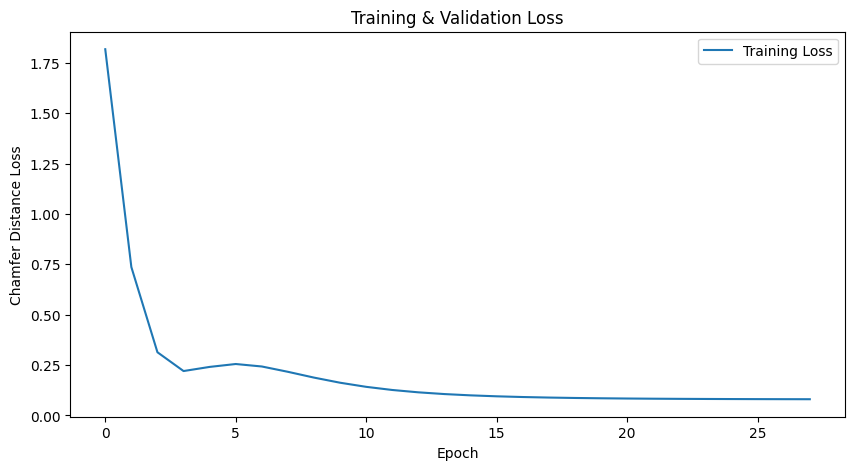

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

torch.Size([1, 1024, 3])
tensor(0.4063)


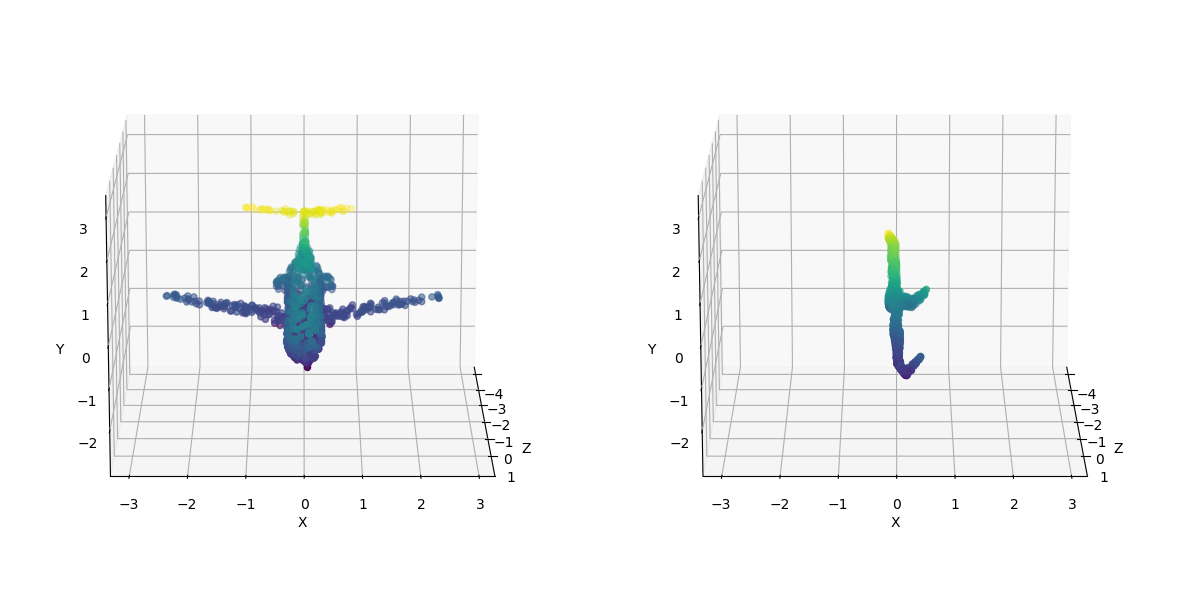

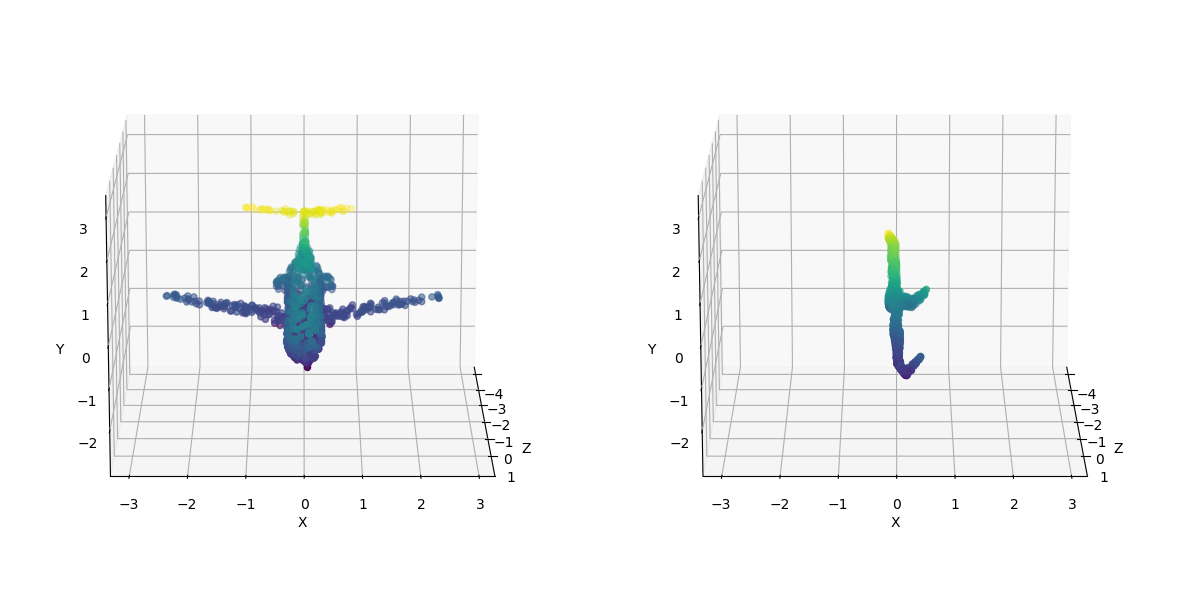

In [ ]:
model.eval()
input = torch.unsqueeze(dataset[0]['train_points'], dim=0)
with torch.no_grad():
  output = model(input) #.view(3072))
print(output.shape)
print(np_chamfer_distance(input, output)[0])
visualize_pointcloud_eval(input.squeeze(), output.squeeze().view(1024, 3))

In [ ]:
print(input[0][0], output[0][0])

tensor([ 0.0775, -0.4271,  3.0487]) tensor([-0.1171,  0.0549,  3.5542])


In [ ]:
from pytorch3d.loss import chamfer_distance